# Import Packages

In [61]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Math Functions

In [62]:
import re


def pw(b, p):
    return np.power(b, p)

def exp(b):
    return np.exp(b)

def sqrt(b):
    return np.sqrt(b)

def pi():
    return np.pi

def ln(a):
    return np.log(a)

# Parameters

In [63]:
# Geometrical Parameters
w_MAM= 0.02
h_MAM= 0.1
L_MAM= 0.2
R_Mit= 0.3
beta= 5.5
epsilon= 1.5
a= 0.02

# SuperOxide Parameters
K_SODc= 0.001
k_SODc= 0.01
K_SODm= 0.001
k_SODm= 0.005
D_S= 10
k_shunt= 0.32
k_IMAC= 0.5
h_IMAC= 3
K_IMAC= 0.004
k_si_S= 3100
k_si_U= 19.2
k_si_IMAC= 5.5

# Calcium Parameters
IP3= 0.0351
W_IP3R= 9.3e3
T_max= 35
K_P_RED= 0.2
D_Ca= 5
D_Ca_e= 50
k_f= 10
V_SERCA= 1.87
K_SERCA= 0.2
K_bar= 0.000019
k_B= 0.4
K_C= 0.2
K_h= 0.08
K_T= 0.1
f_m= 0.005
V_MCU= 0.0056e-3
K_MCU= 50
P1= 0.1
W_MCU= 1e5
V_NCX= 6.4
K_NCX= 30
P2= 0.016
V_OUT= 0.286
K_OUT= 0.3
a0= 0.0027
a1= 0.07
K_e= 8

# IP3R Redox Parameters
k_OX= 45
k_RED= 0.024
K_RED= 0.05
g_max= 0.9
G_OX= 0.05


# Surfaces, Volumes and Volumetric Ratios

In [64]:
# Volumes
V_B= 1000

V_M= 4/3*np.pi*pw(R_Mit, 3)

Tau_S= K_SODc/k_SODc
R_eff= sqrt(D_S*Tau_S)+R_Mit
V_N= 4/3*np.pi*pw(R_eff, 3)#-V_M

V_MAM= h_MAM*L_MAM*w_MAM

# Surfaces and Distances for diffusion
a_MAM= 2*(w_MAM*h_MAM) + 2*(w_MAM*L_MAM)
l_MAM= np.min([h_MAM/2, L_MAM/2])

a_ER= 2*2*pi()*pw(a, 2)
l_ER= R_eff

# Surfaces for Fluxe Ratios
A_Mit_T= 4*pi()*pw(R_Mit, 2)
A_ER_T= 2*pi()*a*2*l_ER
A_MAM= h_MAM*L_MAM

A_Mit= A_MAM/A_Mit_T
# A_ER= pw(pw(V_MAM/(V_MAM+V_N), 1/3), 2)#A_MAM/A_ER_T
A_ER= A_MAM/A_ER_T

# Volumetric Ratios
alpha= V_N/V_B
beta= 5.5
gama= V_N/V_M
delta= V_N/V_MAM
epsilon= 1.5

In [65]:
pw(pw(V_MAM/(V_N), 1/3), 2)

np.float64(0.00123621559150493)

# Diffusion Constants

In [66]:
# SuperOxide
k_S_MAM_N= D_S*a_MAM/l_MAM/V_N
k_S_B_N= 4*pi()*D_S/(1/R_Mit-1/+R_eff)/V_N

# Calcium
k_C_MAM_N= D_Ca*a_MAM/l_MAM/V_N
k_C_B_N= 2*pi()*D_Ca*2*(R_eff)/ln(R_eff/a)/V_N
k_Ce_B_N= D_Ca_e*a_ER*beta/l_ER/V_N


In [67]:
k_C_MAM_N, k_C_B_N, k_S_MAM_N, k_S_B_N, k_Ce_B_N

(np.float64(0.13039549274711498),
 np.float64(2.1262377137309345),
 np.float64(0.26079098549422997),
 np.float64(5.325443786982248),
 np.float64(0.115542172893106))

# Fluxes/Reactions

In [68]:
# SuperOxide
def J_SHUNT():
        return k_shunt
    
def J_IMAC(S_X, S_M):
    return k_IMAC*P_IMAC(S_X)*S_M

def P_IMAC(S_X):
    return 0.001+0.999*pw(S_X, h_IMAC)/(pw(S_X, h_IMAC)+pw(K_IMAC, h_IMAC))

def J_SODm(S_M):
    return k_SODm*S_M/(S_M+K_SODm)

def J_SODc(S_X):
    return k_SODc*S_X/(S_X+K_SODc)

def J_S_MAM_N(S_MAM, S_N):
    return k_S_MAM_N*(S_MAM-S_N)   

def J_S_B_N(S_B, S_N):
    return k_S_B_N*(S_B-S_N)


# Mitochondria Potential
def J_SiS():
    return k_si_S

def J_SiU(Si):
    return k_si_U*Si

def J_SiIMAC(S_X, Si):
    return k_IMAC*P_IMAC(S_X)*Si

# Calcium
def J_IN(C_EB):
    return a0 + a1*pw(K_e, 4)/(pw(K_e, 4)+pw(C_EB, 4))

def J_OUT(C_B):
    return V_OUT*pw(C_B, 2)/(pw(K_OUT, 2)+pw(C_B, 2))

def J_MCU(C_X, Si):
    return V_MCU*pw(C_X, 2)/(pw(K_MCU, 2) + pw(C_X, 2))*exp(P1*Si)

def J_NCX(C_M, Si):
    return V_NCX*C_M/(K_NCX + C_M)*exp(P2*Si)

def J_C_B_N(C_B, C_N):
    return k_C_B_N*(C_B-C_N)   

def J_C_MAM_N(C_MAM, C_N):
    return k_C_MAM_N*(C_MAM-C_N)      

def J_Ce_B_N(Ce_B, Ce_N):
    return k_Ce_B_N*(Ce_B-Ce_N)        

def J_SERCA(C_X, Ce_X):
    return V_SERCA*(pw(C_X, 2)-K_bar*pw(Ce_X, 2))/(pw(C_X, 2)+pw(K_SERCA, 2))

def J_IP3R(OX_X, C_X, h_X, Ce_X):
    RED_X= 1-OX_X
    return k_f*P_o(RED_X, C_X, h_X)*(Ce_X-C_X)

def P_o(OX_X, C_X, h_X):
    RED_X= 1-OX_X
    return B_p(RED_X, C_X, h_X)/(B_p(RED_X, C_X, h_X)+k_B*(B_p(RED_X, C_X, h_X)+a_p(RED_X, C_X)))

def a_p(OX_X, C_X):
    RED_X= 1-OX_X
    return (1-B(RED_X))*(1-m_a(C_X)*h_a(C_X))

def B_p(OX_X, C_X, h_X):
    RED_X= 1-OX_X
    return B(RED_X)*m_a(C_X)*h_X

def m_a(C_X):
    return pw(C_X, 4)/(pw(K_C, 4)+pw(C_X, 4))

def h_a(C_X):
    return pw(K_h, 4)/(pw(K_h, 4)+pw(C_X, 4))

def B(OX_X):
    RED_X= 1-OX_X
    return pw(IP3, 2)/(pw(K_P(RED_X), 2)+pw(IP3, 2))

def T_h(C_X):
    return T_max*pw(K_T, 4)/(pw(K_T, 4)+pw(C_X, 4))

## IP3R Redox
def K_P(OX_X):
    return K_P_RED*(1-g_max*OX_X/(OX_X+G_OX))

def V_OS(S_X, OX_X):
    RED_X= 1-OX_X
    return k_OX*RED_X*S_X

def V_RS(OX_X):
    return k_RED*OX_X / (OX_X + K_RED)


# Model Dynamics

In [69]:
# System of ODEs
def model(t, y):

    S_M= y[0]
    S_MAM= y[1]
    S_N= y[2]
    S_B= y[3]
    Si= y[4]

    C_B= y[5]
    Ce_B= y[6]
    C_N= y[7]
    Ce_N= y[8]
    C_MAM= y[9]
    C_M= y[10]

    h_B= y[11]
    h_N= y[12]
    h_MAM= y[13]

    OX_B= y[14]
    OX_N= y[15]
    OX_MAM= y[16]


    dS_M= J_SHUNT() - J_SODm(S_M) - gama*(1-A_Mit)*(J_IMAC(S_N, S_M)) - gama/delta*A_Mit*(J_IMAC(S_MAM, S_M))
    dS_MAM= A_Mit*(J_IMAC(S_MAM, S_M)) - J_SODc(S_MAM) - delta*(J_S_MAM_N(S_MAM, S_N))
    dS_N= (1-A_Mit)*(J_IMAC(S_N, S_M)) - J_SODc(S_N) + J_S_MAM_N(S_MAM, S_N) + J_S_B_N(S_B, S_N)
    dS_B= -J_SODc(S_B) -alpha*(J_S_B_N(S_B, S_N))  
    dSi= J_SiS() - J_SiU(Si) - (1-A_Mit)*J_SiIMAC(S_N, Si) - A_Mit*J_SiIMAC(S_MAM, Si)

    dC_B= (1-A_ER)*J_IP3R(OX_B, C_B, h_B, Ce_B) - (1-A_ER)*J_SERCA(C_B, Ce_B) - alpha*(J_C_B_N(C_B, C_N)) + epsilon*(J_IN(Ce_B) - J_OUT(C_B))
    dCe_B= beta*((1-A_ER)*J_SERCA(C_B, Ce_B) - (1-A_ER)*J_IP3R(OX_B, C_B, h_B, Ce_B)) - alpha*(J_Ce_B_N(Ce_B, Ce_N))
    dC_N= (1-A_ER)*J_IP3R(OX_N, C_N, h_N, Ce_N) - (1-A_ER)*J_SERCA(C_N, Ce_N) + 1/gama*((1-A_Mit)*(J_NCX(C_M, Si)) - (1-A_Mit)*J_MCU(C_N, Si)) + J_C_MAM_N(C_MAM, C_N) + J_C_B_N(C_B, C_N)
    dCe_N= beta*((1-A_ER)*J_SERCA(C_N, Ce_N) - (1-A_ER)*J_IP3R(OX_N, C_N, h_N, Ce_N)) + beta/delta*(A_ER*J_SERCA(C_MAM, Ce_N) - W_IP3R*A_ER*J_IP3R(OX_MAM, C_MAM, h_MAM, Ce_N)) + J_Ce_B_N(Ce_B, Ce_N)
    dC_MAM= W_IP3R*A_ER*J_IP3R(OX_MAM, C_MAM, h_MAM, Ce_N) - A_ER*J_SERCA(C_MAM, Ce_N) + delta/gama*(A_Mit*(J_NCX(C_M, Si)) - W_MCU*A_Mit*J_MCU(C_MAM, Si)) - delta*(J_C_MAM_N(C_MAM, C_N))
    dC_M= f_m*((1-A_Mit)*J_MCU(C_N, Si) + W_MCU*A_Mit*J_MCU(C_MAM, Si) - J_NCX(C_M, Si))

    dh_B= (h_a(C_B)-h_B)/T_h(C_B)
    dh_N= (h_a(C_N)-h_N)/T_h(C_N)
    dh_MAM= (h_a(C_MAM)-h_MAM)/T_h(C_MAM)

    dOX_B= V_OS(S_B, OX_B) - V_RS(OX_B)
    dRED_N= V_OS(S_N, OX_N) - V_RS(OX_N)
    dRED_MAM= V_OS(S_MAM, OX_MAM) - V_RS(OX_MAM)
    
    return [dS_M, dS_MAM, dS_N, dS_B, dSi, dC_B, dCe_B, dC_N, dCe_N, dC_MAM, dC_M, dh_B, dh_N, dh_MAM, dOX_B, dRED_N, dRED_MAM]


# Initial Condition

In [70]:
S_M0= 0.00001
S_MAM0= 0.00001
S_N0= 0.00001
S_B0= 0.00001
Si0= 157
C_B0= 0.01
Ce_B0= 13
C_N0= 0.01
Ce_N0= 13
C_MAM0= 0.01
C_M0= 0.01
h_B0= 0.0001
h_N0= 0.0001
h_MAM0= 0.0001
RED_B0= 0.99
RED_N0= 0.99
RED_MAM0= 0.99
z0= (S_M0, S_MAM0, S_N0, S_B0, Si0, C_B0, Ce_B0, C_N0, Ce_N0, C_MAM0, C_M0, h_B0, h_N0, h_MAM0, RED_B0, RED_N0, RED_MAM0)

# Time Steps

In [71]:
Time= 300
dt= 0.01
t= np.linspace(0, Time, int((Time/dt)+1))
t= np.around(t, decimals= 4)

# Model Solution

In [ ]:
z= solve_ivp(model, (0, Time), z0, t_eval= t, method= 'Radau', rtol= 1e-8)

# Plot Solution

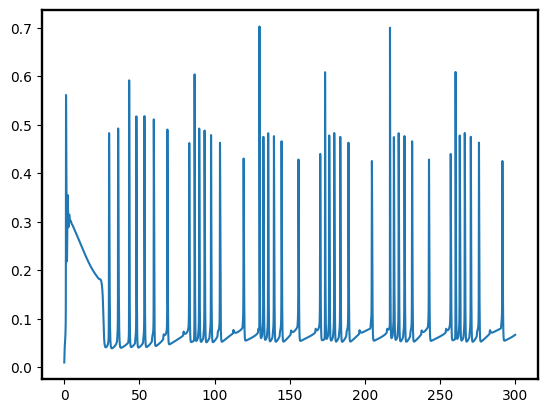

In [ ]:
plt.plot(z.t, z.y[7])

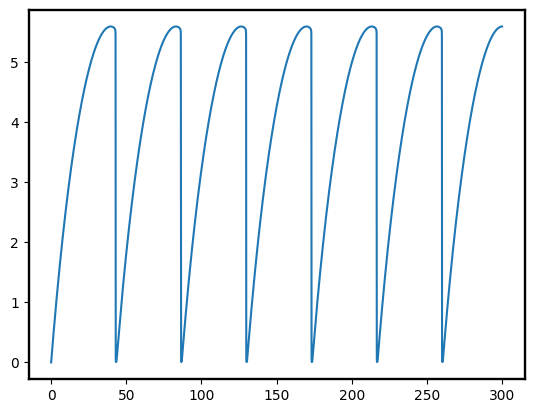

In [ ]:
plt.plot(z.t, z.y[0])

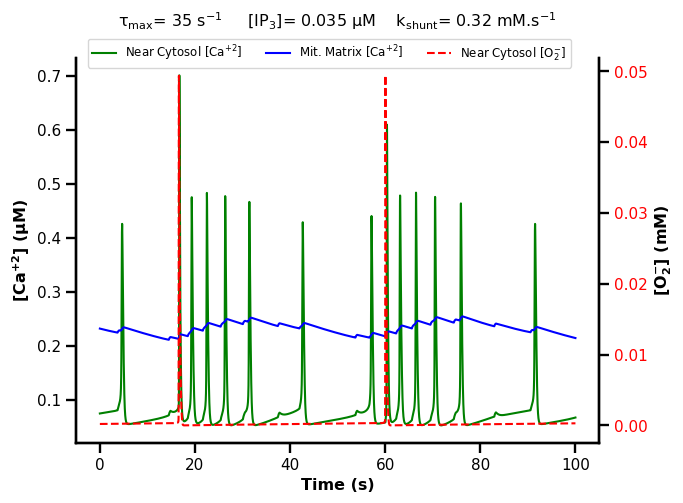

In [ ]:
ts= 200*100
te= 300*100
le= te-ts
st= 0
dt= 0.01
en= (te-ts-1)*dt
t= np.linspace(st, en, le)

plt.rcParams['mathtext.default'] = 'regular'  # فعال‌سازی mathtext معمولی
plt.rcParams['mathtext.fontset'] = 'stix'  # انتخاب فونت سازگار با توان و اندیس
plt.rcParams['axes.linewidth']= 1.7


select_kshunt, select_IP3= 0.32, 0.035

i= z.y[7]
j= z.y[10]
# k= sol_real['Sol']['RED_N']
# l= sol_max['Sol']['RED_N']
m= z.y[2]
h= 5
size= (h*1.35, h)
fig, ax1 = plt.subplots(figsize=size)
line1, =ax1.plot(t, i[ts:te], color= 'Green', label= r'Near Cytosol [Ca$^{+2}$]')
line2, =ax1.plot(t, j[ts:te], color= 'Blue', label= r'Mit. Matrix [Ca$^{+2}$]')
ax1.set_ylabel(r'[Ca$^{+2}$] (μM)', fontsize=11.5, fontweight='bold')

ax2= ax1.twinx()
line3,= ax2.plot(t, m[ts:te], color= 'Red', linestyle= '--', label= r'Near Cytosol [$O_2^{-}$]')
ax2.set_ylabel(r'[$O_2^{-}$] (mM)', fontsize=11.5, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='r')
# ax2.set_yscale('log')

fig.legend(handles=[line1, line2, line3], bbox_to_anchor=(0.5, 0.93), loc='upper center', ncol=3, prop={'size': 8.5})
ax1.spines[['top',]].set_visible(False)
ax2.spines[['top',]].set_visible(False)
ax1.tick_params(axis='both', which='major', labelsize=11, width=1.7, length=7)
ax2.tick_params(axis='both', which='major', labelsize=11, width=1.7, length=7)
ax1.set_xlabel(r'Time (s)', fontsize=11.5, fontweight='bold')
ax1.set_title(r'$τ_{max}$= 35 s$^{-1}$     [$IP_3$]= 0.035 μM    $k_{shunt}$= 0.32 mM.s$^{-1}$', fontsize=11.5, y= 1.06)#, fontweight='bold', y= 1.06)

# fig.savefig('Osc_kshunt_Vs_IP3_Cal_TimeSerie.png', bbox_inches='tight', dpi=600)
# fig.savefig('Osc_kshunt_Vs_IP3_Kp_TimeSerie.png', bbox_inches='tight', dpi=600)
plt.show()